In [ ]:
#!/usr/bin/env python
# coding: utf-8

# ### Calculate DG83 index
# Method adapted from Pinheiro et al. (2019). This uses four thresholds to apply for the blocking criterea, which are applied in turn:
#     
#     AMPLITUDE - count the number of grid squares exceeding the var threshold (which may be -ve or +ve if one looks at the anomalies or not)
#     AREA - for each blocked region count the number of grid cells at each latitude and so calculate the total area of each blocked region
#     PERSISTENCE - measure how long the block persists for, and set a threshold for at least five days
#     OVERLAP - count the number of days over which the contours for the blocked region overlap
# 
# If all of these criterea are met, then blocked_day = True. Else blocked_day = False.
#     
# These thresholds are applied to two datasets: 500hPa geopotentiel height anomalies, detrended wrt surface temperature (creating a measure similar to Dole and Gordon (1983)) and the seasonal anomaly of vertically averaged potential vorticity (similar to Schweirz (2004)).  The calculation of the anomaly fields and detrending has been done in a separate notebook, and uses ``cdo`` commands: https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf


In [34]:
import xarray
import numpy as np
import scipy
import glob
import matplotlib.pyplot as plt
#import PDF_funcs
from scipy import stats
from itertools import groupby
from operator import itemgetter
#for mapping the polygon on a sphere to a polygon on a flat surface to calculate area
import pyproj
import math
from shapely import geometry
import collections
import matplotlib.pyplot as plt
import xarray as xr
import sys
from scipy import stats


In [2]:



def len_iter(items):
    return sum(1 for _ in items)

def consecutive_one(data):
    return max(len_iter(run) for val, run in groupby(data) if val)

def test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid):
    """
    test centroid position
    """
    if len([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid]) == 1:
        centroid_pos = ([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid][0])
        var_bool_blocked_idx[cluster[centroid_pos][0], cluster[centroid_pos][1]] = 2
        return True
    else:
        return False

def identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx):
    """
    Identify the location(s) of the centroid within the cluster
    function contains exception handling for if the centroid position (identified using the median lat/lon values)
    is not in the list
    Note that this has been written for a grid resolution of 2x2 - other grid resolutions e.g. 2.5x2.5 might have errors
    """
    try:
        centroid_pos = ([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid][0])
        var_bool_blocked_idx[cluster[centroid_pos][0], cluster[centroid_pos][1]] = 2
    except IndexError: #when the centroid_pos is not within the cluster (the median lat/lon value isn't part of the cluster)
        #need to adjust lat_centroid and lon_centroid until the closest centre within the cluster is identified
        centroid_not_found = True
        while centroid_not_found:
            for i in range(1,len(lat)):
                #loop through all possible centroid locations starting out from the median location
                #so that if there are two possible locations of the centroid within the cluster both are chosen
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid-i)
                if centroid_pos_found:
                    centroid_not_found = False #break loop here when the nearest neighbours have been checked
                #if still not found, look at the edge tiles
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid-i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid-i)
                if centroid_pos_found: #break loop here when the edge tiles have been checked before looping back through
                    centroid_not_found = False



def get_adjacent_indices(i, j, m, n):
    """
    Obtain the adjacent indices where they can be found
    uses the nearest neighbour
    from https://stackoverflow.com/questions/51657128/how-to-access-the-adjacent-cells-of-each-elements-of-matrix-in-python/51657232
    """
    adjacent_indices = []
    if i > 0:
        adjacent_indices.append((i-1,j))
    if i+1 < m:
        adjacent_indices.append((i+1,j))
    if j > 0:
        adjacent_indices.append((i,j-1))
    if j+1 < n:
        adjacent_indices.append((i,j+1))
    return adjacent_indices

def add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals, lat_lon_idx_vals, len_lat, len_lon):
    """
    If not already in the cluster, add adjacent values to the cluster
    """
    if ((lat_idx, lon_idx)) not in cluster:
        #print(f"{(lat_idx, lon_idx)} added to cluster")
        cluster.append((lat_idx, lon_idx))
    adjacent_indices = get_adjacent_indices(lat_idx, lon_idx, len_lat, len_lon)
    #print(f"adjacent_indices = {adjacent_indices}")
    for adj_idx in adjacent_indices:
        if adj_idx in lat_lon_idx_vals:
            if adj_idx not in cluster:
                #add the value and the adjacent values to the cluster
                cluster.append(adj_idx)  
                if adj_idx not in idx_vals:
                    idx_vals.append(adj_idx) # these are the new index values that are going to be iterated over again

    return idx_vals
            
def calc_clusters(var_bool, len_lat, len_lon):
    """
    Returns a list of grouped clusters using the nearest neighbour
    """
    lat_idx_vals, lon_idx_vals = np.where(var_bool > 0)
    lat_lon_idx_vals = [(lat_idx, lon_idx) for lat_idx, lon_idx in zip(lat_idx_vals, lon_idx_vals)]
    cluster, cluster_arr = [], []
    #print(lat_lon_idx_vals)
    for i in range(lon_idx_vals.shape[0]):
        #print(i)
        #need to find in the whole array if there are any matching index values that are adjacent and haven't already been put into the cluster
        lat_idx, lon_idx = lat_lon_idx_vals[i]
        #print(lat_idx, lon_idx)
        if sum([(lat_idx, lon_idx) in cluster for cluster in cluster_arr]) == 0: #check if lat or lon index already in a cluster
            cluster, idx_vals = [], []
            idx_vals = add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals, lat_lon_idx_vals, len_lat, len_lon)
            num_idx_vals = len(idx_vals) # number of idx vals in cluster not looped across yet
            #print(f"num_idx_vals = {num_idx_vals}")
            idx_vals_old, idx_vals_new = idx_vals.copy(), idx_vals.copy()
            while (num_idx_vals > 0): # while there are still index values in the nearest neighbour
                #loop through all the adjacent values that are also blocked
                for lat_idx, lon_idx in (idx_vals_old):
                    #for each adjacent value that is also blocked, identify the new index values
                    idx_vals_new = add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals_new, lat_lon_idx_vals, len_lat, len_lon)
                    #remove the idx_val that has been looped over from the list
                    idx_vals_new.remove((lat_idx, lon_idx))                
                idx_vals_old = idx_vals_new.copy()
                #print(f"num_idx_vlas = {len(idx_vals_old)}")
                num_idx_vals = len(idx_vals_old)
                #if num_idx_vals == 0:
                    #print("HERE")
                    #break
            cluster_arr.append((cluster))
        else:
            pass #here if current index in loop is already in a cluster

    return cluster_arr    
    


# In[9]:


#adapted from https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx+1

def area_test(var_bool_samp, lat, lon, area_thresh, lon_corr, area_cell, time_val, i):
    """
    Calculate the polygon shapes, determine the area for the blocked polygons and if there is a
    blocked polygon identify whether or not it passes the area_thresh threshold
    if so, then day is blocked
    #Length of 1 degree of Longitude = cosine (latitude in decimal degrees) * length of degree (miles) at equator
    #Each degree of latitude is approximately 69 miles (111 kilometers) apart
    #The range varies (due to the earth's slightly ellipsoid shape) from 68.703 miles (110.567 km) at the equator to 69.407 (111.699 km) at the poles    
    """
    blocked_day = 0
    
    #plt.pcolormesh(lon,lat,var_bool_samp)
    #CS = plt.contour(lon,lat,var_bool)# corner_mask=True,interpolation='none')
    #print(f"var_bool.sum() = {var_bool.sum()}")
    #plt.close()
    #plt.pcolormesh(lon,lat,var_bool)
    #fig=plt.figure()
    #plt.pcolormesh(lon,lat,var_bool)
    var_bool_blocked_idx = np.zeros((len(lat),len(lon)))#use to identify blocked regions
    cluster_num = 0

    var_bool_blocked_idx=xarray.DataArray(var_bool_samp*0, name = "TM90_clusters", coords=var_bool_samp.coords)
    #print(f"var_bool_blocked_idx = {var_bool_blocked_idx}")
    #calculate all of the clusters for this time step
    cluster_arr = calc_clusters(var_bool_samp, len(lat), len(lon))
    #print(f"var_bool_samp.sum() = {var_bool_samp.sum()}")
    for cluster in cluster_arr:
        #calculate the area of different clusters by projecting the lat/lon values onto a boolean lat/lon grid area_cell grid
        #and multiplying this by the area_cell grid to obtain the area
        
        #print(f"cluster = {cluster}")
        var_bool_cluster = np.zeros((len(lat),len(lon)))
        for lat_idx, lon_idx in cluster:
            #print(f"lat_idx, lon_idx = {lat_idx, lon_idx}")
            
            var_bool_cluster[lat_idx,lon_idx] = 1
        #fig = plt.figure()
        #plt.pcolormesh(lon,lat,var_bool_cluster)            
        #print(f"var_bool_cluster = {var_bool_cluster}")    
        area_cell_sum=(area_cell*var_bool_cluster).sum().values
        #plt.pcolormesh(lon,lat,area_cell) 
        #plt.colorbar()
        #print(f"var_bool_cluster.sum() = {var_bool_cluster.sum()}")
        #print(f"area_cell_sum = {area_cell_sum} km^2")
        #print(f"area_cell_sum_tot = {area_cell.sum().values} km^2")
        
        #if this area > area_thresh, add the cluster to the 2D lat/lon grid for overlap calculation
        if area_cell_sum > area_thresh:
            #print("BLOCKED")
            #label day as blocked
            cluster_num += 1
            blocked_day = 1
            for lat_idxs, lon_idxs in cluster:
                var_bool_blocked_idx[lat_idxs,lon_idxs]=1
            #label the centre lat, lon idx value with a 2
            lats_arr, lons_arr = ([i[0] for i in cluster], [i[1] for i in cluster])
            lat_centroid, lon_centroid = (np.median(lats_arr), np.median(lons_arr))
            # if there isn't a value in the middle then set the two neighbouring middle indices to 2 (effectively blur the two centroids)
            #otherwise there would be a bias to highlighting blicking in E/W or N/S directions
            if lon_centroid%1 == 0 and lat_centroid%1 == 0:  
                #print(lat_centroid, lon_centroid)
                #print(cluster)
                identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx)
            else: # if there isn't a value in the middle then set the two neighbouring middle indices to 2 (effectively blur the two centroids)
                if lat_centroid%1 != 0:
                    lat_centroid_arr = [lat_centroid-0.5, lat_centroid+0.5]
                    lon_centroid_arr = [lon_centroid, lon_centroid]
                if lon_centroid%1 != 0:
                    lat_centroid_arr = [lat_centroid, lat_centroid]
                    lon_centroid_arr = [lon_centroid-0.5, lon_centroid+0.5]
                if lon_centroid%1 != 0 and lat_centroid%1 != 0:    #when no middle lat or lon - create a centroid blob containing 4 tiles
                    lon_centroid_arr = [lon_centroid-0.5, lon_centroid+0.5, lon_centroid-0.5, lon_centroid+0.5]
                    lat_centroid_arr = [lat_centroid-0.5, lat_centroid+0.5, lat_centroid+0.5, lat_centroid-0.5]
                for lat_centroid, lon_centroid in zip(lat_centroid_arr, lon_centroid_arr):
                    identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx)
    return var_bool_blocked_idx, cluster_num


In [27]:
zg_anom = xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/zg/"
                "500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_EUR_anom.nc")['zg'].squeeze()

In [10]:
sorted(glob.glob(("/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/zg/*")))

['/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_EUR.nc',
 '/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_EUR_anom.nc',
 '/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_EUR_ydayavg.nc',
 '/rds/general/project/carl_phd/live/carl/data/cmip6/UKESM1-0-LL/piControl/day/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_NHML.nc']

In [18]:
EUR_zg=xr.open_dataset('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
                       '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR.nc')['zg'].squeeze()
EUR2_zg=xr.open_dataset('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
                        '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2.nc')['zg'].squeeze()

In [32]:
EUR_zg_JJAextd = EUR_zg.sel(time=np.isin(EUR_zg['time.dayofyear'], np.arange(147,245)))

In [40]:
EUR_zg_JJAextd_times=[EUR_zg_JJAextd[i]*0+i for i in range(EUR_zg_JJAextd.shape[0])]

In [41]:
x=xr.concat(EUR_zg_JJAextd_times, dim="time")

In [45]:
#time detrend
#stats.linregress(range(9898), EUR_zg_JJAextd[:,0,0])

y = EUR_zg_JJAextd
#y['longitude']=x['longitude']
Sum_x, Sum_y = (x.sum(axis=0)), (y.sum(axis=0))
print("calculated sum")
Sum_x2 = (x*x).sum(axis=0)
Sum_y2 = (y*y).sum(axis=0)
Sum_xy = (x*y).sum(axis=0)
mean = float(y.mean())
print("calculated mixed terms") 
#print(Sum_xy, Sum_x2, Sum_y2)
n = x.shape[0]
m = (n*Sum_xy - Sum_x*Sum_y) / (n*Sum_x2 - Sum_x**2)
c = (Sum_y*Sum_x2 - Sum_x*Sum_xy) / (n*Sum_x2 - Sum_x**2)


#EUR_zg_JJAextd_dtrnd = 

calculated sum
calculated mixed terms


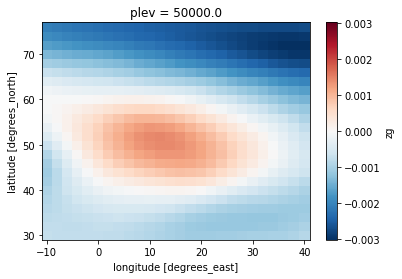

In [59]:
m.plot()

In [62]:
time_trend = m*x+c

In [68]:
EUR_zg_JJAextd_dtrnd = EUR_zg_JJAextd-time_trend

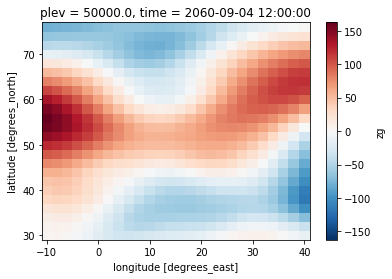

In [77]:
EUR_zg_JJAextd_dtrnd[-1].plot()

In [79]:
EUR_zg_JJAextd_dtrnd.to_netcdf('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
                       '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd.nc')

In [84]:

#dp latitude correction

lat_corr=np.sin(np.radians(45))/np.sin(np.radians(EUR_zg_JJAextd_dtrnd['lat']))


zg_lat_corr=EUR_zg_JJAextd_dtrnd*lat_corr
zg_lat_corr_rn=xr.DataArray(EUR_zg_JJAextd_dtrnd, name="zg")
zg_lat_corr_rn.to_netcdf('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
                       '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd_latcorr.nc')
#cdo timstd 500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd_latcorr.nc
#500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd_latcorr_timstd.nc

In [95]:

zg_file=xr.open_dataset('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
    '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd_latcorr.nc')['zg'].squeeze()

zg_file_timstd=xr.open_dataset('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
    '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd_latcorr_timstd.nc')['zg'].squeeze()

In [93]:
amp_min_anom_thresh = 100
var_anom_thresh_arr = zg_file_timstd*1.5
var_anom_minthresh_arr = np.asarray(np.where(var_anom_thresh_arr < amp_min_anom_thresh))
if var_anom_minthresh_arr.shape[1] > 0:
    for var_anom_minthresh_lat, var_anom_minthresh_lon in zip(var_anom_minthresh_arr[0], var_anom_minthresh_arr[1]):
        var_anom_thresh_arr[var_anom_minthresh_lat, var_anom_minthresh_lon] = amp_min_anom_thresh

In [96]:
var_bool=(zg_file>var_anom_thresh_arr)

In [99]:
var_bool.to_netcdf('/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/'
    '500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR_JJAextd_dtrnd_latcorr_DG83bool.nc')
#.mean(axis=0).plot()

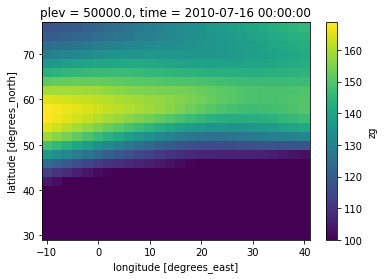

In [94]:
var_anom_thresh_arr.plot()

In [3]:
var_bool=xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/"
                         "500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd_DG83bool.nc")


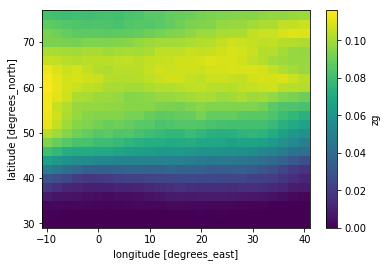

In [7]:
var_bool['zg'].mean(axis=0).plot()

In [3]:
xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/500zg_day_era5_reanal_1979-2019_EUR2_JJAextd_dtrnd_DG83bool.nc")

<xarray.Dataset>
Dimensions:    (latitude: 46, longitude: 51, time: 4100)
Coordinates:
  * time       (time) datetime64[ns] 1979-05-28T10:30:00 ... 2019-09-04T10:30:00
  * latitude   (latitude) float32 30.0 31.0 32.0 33.0 ... 72.0 73.0 74.0 75.0
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0 40.0
Data variables:
    zg         (time, latitude, longitude) bool ...

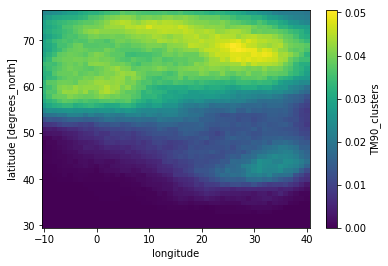

In [5]:
S04=xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_era5_reanal_EUR_ssp585_JJAextd_1979-2019.nc")['TM90_clusters']


S04.mean(axis=0).plot()

In [4]:
xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort.nc")['z']

<xarray.DataArray 'z' (time: 4100, latitude: 46, longitude: 51)>
[9618600 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1979-05-28T10:30:00 ... 2019-09-04T10:30:00
  * latitude   (latitude) float32 30.0 31.0 32.0 33.0 ... 72.0 73.0 74.0 75.0
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0 40.0

In [7]:
#apply lat_corr to DG83 data - ERA5

zg_file = xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort.nc")['z']


lat_corr=np.sin(np.radians(45))/np.sin(np.radians(zg_file['latitude']))


zg_lat_corr=zg_file*lat_corr
zg_lat_corr_rn=xr.DataArray(zg_lat_corr, name="zg")
zg_lat_corr_rn.to_netcdf("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort_latcorr.nc")


In [ ]:

cd /rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/
cdo timstd z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort_latcorr.nc  z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort_latcorr_timstd.nc

In [89]:

#create var_bool file for ERA5 DG83:

zg_file=xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort_latcorr.nc")['zg']
zg_file_timstd=xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort_latcorr_timstd.nc")['zg'].squeeze()


In [90]:
amp_min_anom_thresh = 100
var_anom_thresh_arr = zg_file_timstd*1.5
var_anom_minthresh_arr = np.asarray(np.where(var_anom_thresh_arr < amp_min_anom_thresh))
if var_anom_minthresh_arr.shape[1] > 0:
    for var_anom_minthresh_lat, var_anom_minthresh_lon in zip(var_anom_minthresh_arr[0], var_anom_minthresh_arr[1]):
        var_anom_thresh_arr[var_anom_minthresh_lat, var_anom_minthresh_lon] = amp_min_anom_thresh

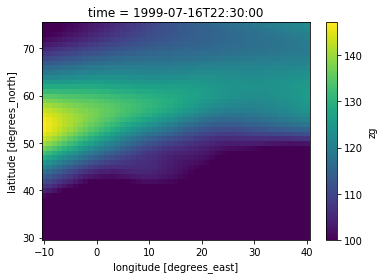

In [91]:
var_anom_thresh_arr.plot()#ERA5 zg

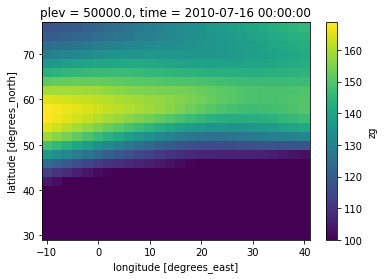

In [88]:
var_anom_thresh_arr.plot()#UKESM zg

In [11]:
var_bool=(zg_file>var_anom_thresh_arr)

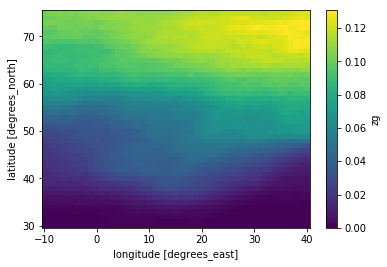

In [13]:
var_bool.mean(axis=0).plot()

In [14]:
var_bool.to_netcdf("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/500zg_day_era5_reanal_1979-2019_EUR2_JJAextd_dtrnd_DG83bool.nc")


In [38]:
#apply lat_corr to DG83 data - UKESM

zg_file = xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd.nc")['zg']


lat_corr=np.sin(np.radians(45))/np.sin(np.radians(zg_file['lat']))


zg_lat_corr=zg_file*lat_corr
zg_lat_corr_rn=xr.DataArray(zg_lat_corr, name="zg")
zg_lat_corr_rn.to_netcdf("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd_latcorr.nc")


In [5]:
##create var_bool file for UKESM1-0-LL DG83:

zg_file=xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd_latcorr.nc")['zg']
zg_file_timstd=xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd_latcorr_timstd.nc")['zg'].squeeze()


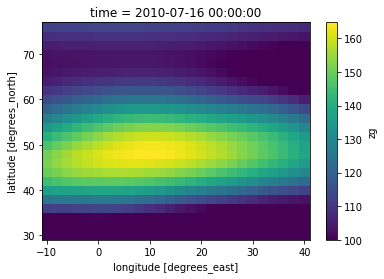

In [23]:
var_anom_thresh_arr.plot()

In [26]:
var_bool=(zg_file>var_anom_thresh_arr)

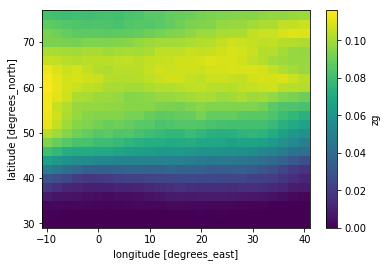

In [29]:
var_bool.mean(axis=0).plot()

In [31]:
var_bool.to_netcdf("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/"
    "500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd_DG83bool.nc")


In [15]:
xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/S04/block_data/S04_clusters_era5_reanal_EUR_ssp585_JJAextd_2019.nc")

<xarray.Dataset>
Dimensions:        (latitude: 47, longitude: 51, time: 100)
Coordinates:
  * longitude      (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 38.0 39.0 40.0
  * latitude       (latitude) float32 30.0 31.0 32.0 33.0 ... 74.0 75.0 76.0
  * time           (time) datetime64[ns] 2019-05-28T10:30:00 ... 2019-09-04T10:30:00
Data variables:
    TM90_clusters  (time, latitude, longitude) int64 ...

In [ ]:
#/rds/general/user/cmt3718/home/data/reanal/S04/block_data/*S04_clusters_era5_reanal_EUR_ssp585_JJAextd_*

In [106]:
#implelemnt the amplitude criterea (as above but normalised for when the file is loaded again)
#this is the file that is used from the rest of the notebook to implement the other blocking criterea
#zg_dtrnd_areaweighted_DG83_varbool=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/"
#                                            "500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83_bool.nc")['500zg']


#run cell for TM90 calculations
TM902D_arr = sorted(glob.glob("/rds/general/user/cmt3718/home/data/cmip5/TM90_2D/*TM902D*"))
#TM902D_arr.remove('/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/TM902D_CESM2_r10i1p1f1_EURATL_ssp585_JJAextd_1939-1939tot.nc')

#TM902D_arr = ["/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/TM902D_AWI-CM-1-1-MR_r1i1p1f1_EURATL_ssp585_JJAextd_2015-2100tot.nc"]
lons_arr = [170-180,220-180]
lats_arr = [30,76]
domain = "EUR"
grid_res = 2
lat_str, lon_str = "lat", "lon"
    
#var_bool#=xr.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/vpv_1x1_150-500hPa_1979-2019_tot_daymean_hires_LTDManom_bool_neg_inv_bool_JJAextdEUR.nc")['VPV']
#xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd_DG83bool.nc")['zg']

    #"/rds/general/project/carl_phd/live/carl/data/era5/day/zg/"
    #                                        "500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83_bool.nc")['500zg']    
#var_bool = xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/"
#                                    "pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_bool.nc")['__xarray_dataarray_variable__']

#qsub -v SCRIPT=/rds/general/user/cmt3718/home/notebooks/area_thresh-era5-2.py ipython_qsub.sh
    
lat, lon = var_bool[lat_str], var_bool[lon_str]
#these variables can be modified
area_thresh = 1e6 # minimum blocked area in km^2
# 1e6 km^2 is a reasonable minimum area since this is approximately the squared radius of a typical anticyclone (pg 10 of Hoskins & James)
#grid_res = 1 #grid resolution
#create a tuple of the lat/lon coordinates of the grid to test whether or not the grid cells exist within the point
lats, lons = np.asarray(np.meshgrid(lat,lon))[0,:,:].flatten(), np.asarray(np.meshgrid(lat,lon))[1,:,:].flatten()
grid_coords = list(zip(lats,lons-180))
#rough minimum for the number of grid cells needed for a blocking event
min_num_grid_cells=area_thresh*np.cos(np.radians(30))/(grid_res*grid_res*110*110) #0.25x0.25 grid x 110km (roughly 1/360 of Earth's circumference)
#minimum proportion of grid cells to block
prop_blocked_thresh = min_num_grid_cells/(len(lat)*len(lon))

lon_corr = [True if var_bool[lon_str].max() > 180 else False][0]
if lon_corr:
    lon = lon - 180
mdl, ens, styr, endyr = "UKESM1-0-LL", "r1i1p1f2_piControl", 1960, 2060#TM902D_str.split("_")[2], TM902D_str.split("_")[3], TM902D_str.split("_")[-1][:4], TM902D_str.split("_")[-1][5:9]
#create a DataArray where each element corresponds to the area of that cell
area_cell=xr.DataArray(var_bool[0,:,:],name = "grid_cell_area")*0+1
area_cell[:,:] = area_cell[:,:]*(np.cos(np.radians(var_bool[lat_str][:]))*111*grid_res)*(111*grid_res)   
time, lat, lon = var_bool['time'], var_bool[lat_str], var_bool[lon_str]
blocked_day_arr = np.zeros((len(var_bool['time'])))
print(mdl,ens,styr,endyr)
var_bool_blocked_arr = []
cs_2003_idxvals = np.arange(24*92+62,24*92+74+1)
cs_2019_idxvals = np.arange(-92+20,-92+23+10)

JJA_days = len(np.unique(var_bool['time.dayofyear']))



for year_num in range(0,101):
    year = 1960+year_num
    var_bool_blocked_arr=[]
    for i in np.arange(year_num*JJA_days,(year_num+1)*JJA_days):
        #if i%2 == 0:
        #print(f"calculating day {i} for year {year}")
            #print(f"{100*i/time.shape[0]}% done")
        var_bool_blocked, cluster_num = area_test(var_bool[i,:,:], lat, lon, area_thresh, lon_corr, area_cell, var_bool['time'][i], i)
                    #fig = plt.figure()
                    #plt.pcolormesh(lon,lat,var_bool_blocked)
                    ##var_bool_samp, lat, lon, area_thresh, lon_corr, area_cell, time_val
        var_bool_blocked_arr.append(var_bool_blocked)
    var_bool_blocked_clusters = xarray.concat(var_bool_blocked_arr, dim='time')
    var_bool_blocked_clusters.to_netcdf(f"/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/DG83/DG83_clusters_{mdl}_{ens}_{domain}_ssp585_JJAextd_{year}.nc")
        #f"/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_{mdl}_{ens}_{domain}_ssp585_JJAextd_{year}.nc")
        #f"/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/AGP/DG83_clusters_{mdl}_{ens}_{domain}_ssp585_JJA_{year}.nc")



UKESM1-0-LL r1i1p1f2_piControl 1960 2060


In [108]:
DG83=xr.open_dataset("/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/DG83/DG83_clusters_UKESM1-0-LL_r1i1p1f2_piControl_EUR_ssp585_JJAextd_1960-2060.nc")['TM90_clusters']

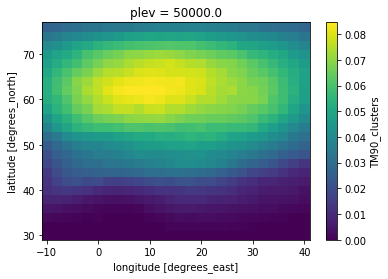

In [110]:
DG83.mean(axis=0).plot()

In [103]:
len(np.unique(var_bool['time.dayofyear']))

98

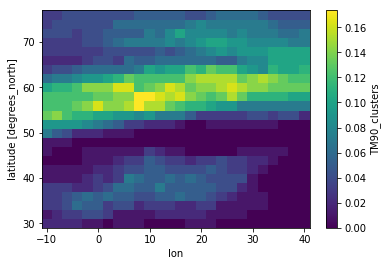

In [18]:
var_bool_blocked_clusters.mean(axis=0).plot()

In [ ]:
#implelemnt the amplitude criterea (as above but normalised for when the file is loaded again)
#this is the file that is used from the rest of the notebook to implement the other blocking criterea
zg_dtrnd_areaweighted_DG83_varbool=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/"
                                            "500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83_bool.nc")['500zg']


#run cell for TM90 calculations
TM902D_arr = sorted(glob.glob("/rds/general/user/cmt3718/home/data/cmip5/TM90_2D/*TM902D*"))
#TM902D_arr.remove('/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/TM902D_CESM2_r10i1p1f1_EURATL_ssp585_JJAextd_1939-1939tot.nc')

#TM902D_arr = ["/rds/general/user/cmt3718/home/data/cmip6/TM90_2D/TM902D_AWI-CM-1-1-MR_r1i1p1f1_EURATL_ssp585_JJAextd_2015-2100tot.nc"]
lons_arr = [170,220]
lats_arr = [30,76]
domain = "EUR"
grid_res = 1
lat_str, lon_str = "latitude", "longitude"
    
var_bool=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/"
                                            "500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83_bool.nc")['500zg']    
#var_bool = xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/"
#                                    "pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_bool.nc")['__xarray_dataarray_variable__']

#qsub -v SCRIPT=/rds/general/user/cmt3718/home/notebooks/area_thresh-era5-2.py ipython_qsub.sh
    
lat, lon = var_bool[lat_str], var_bool[lon_str]
#these variables can be modified
area_thresh = 1e6 # minimum blocked area in km^2
# 1e6 km^2 is a reasonable minimum area since this is approximately the squared radius of a typical anticyclone (pg 10 of Hoskins & James)
#grid_res = 1 #grid resolution
#create a tuple of the lat/lon coordinates of the grid to test whether or not the grid cells exist within the point
lats, lons = np.asarray(np.meshgrid(lat,lon))[0,:,:].flatten(), np.asarray(np.meshgrid(lat,lon))[1,:,:].flatten()
grid_coords = list(zip(lats,lons-180))
#rough minimum for the number of grid cells needed for a blocking event
min_num_grid_cells=area_thresh*np.cos(np.radians(30))/(grid_res*grid_res*110*110) #0.25x0.25 grid x 110km (roughly 1/360 of Earth's circumference)
#minimum proportion of grid cells to block
prop_blocked_thresh = min_num_grid_cells/(len(lat)*len(lon))

lon_corr = [True if var_bool[lon_str].max() > 180 else False][0]
if lon_corr:
    lon = lon - 180
mdl, ens, styr, endyr = "era5", "reanal", 1979, 2019#TM902D_str.split("_")[2], TM902D_str.split("_")[3], TM902D_str.split("_")[-1][:4], TM902D_str.split("_")[-1][5:9]
#create a DataArray where each element corresponds to the area of that cell
area_cell=xr.DataArray(var_bool[0,:,:],name = "grid_cell_area")*0+1
area_cell[:,:] = area_cell[:,:]*(np.cos(np.radians(var_bool[lat_str][:]))*111*grid_res)*(111*grid_res)   
time, lat, lon = var_bool['time'], var_bool['latitude'], var_bool['longitude']
blocked_day_arr = np.zeros((len(var_bool['time'])))
print(mdl,ens,styr,endyr)
var_bool_blocked_arr = []
cs_2003_idxvals = np.arange(24*92+62,24*92+74+1)
cs_2019_idxvals = np.arange(-92+20,-92+23+10)

for i in np.arange(year_num*92,(year_num+1)*92):#specify here the values needed for the 
    #if i%2 == 0:
    print(f"calculating day {i} for year {year}")
        #print(f"{100*i/time.shape[0]}% done")
    var_bool_blocked, cluster_num = area_test(var_bool[i,:,:], lat, lon, area_thresh, lon_corr, area_cell, var_bool['time'][i], i)
                #fig = plt.figure()
                #plt.pcolormesh(lon,lat,var_bool_blocked)
                ##var_bool_samp, lat, lon, area_thresh, lon_corr, area_cell, time_val
    var_bool_blocked_arr.append(var_bool_blocked)
var_bool_blocked_clusters = xarray.concat(var_bool_blocked_arr, dim='time')
var_bool_blocked_clusters.to_netcdf(f"/rds/general/user/cmt3718/home/data/reanal/DG83/block_data/DG83_clusters_{mdl}_{ens}_{domain}_ssp585_JJA_{year}.nc")

